# Семинар 4: аппроксимация Q-функции

## Майнор ВШЭ, 14.02.2019

Опрос на сегодня - https://goo.gl/forms/kVa5qtBLavZh0tN93.

В этой тетрадке мы будем использовать библиотеку __tensorflow__ для обучения нейронной сети, хотя можно использвать и любую другую библиотеку. 

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Будем тестировать наши модели на классической задаче с перевернутым маятником.

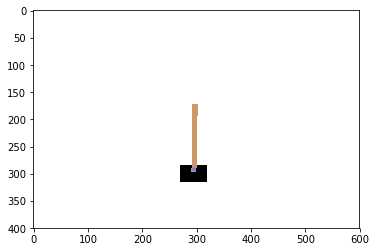

In [2]:
env = gym.make("CartPole-v0").env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

In [3]:
env.close()

# Глубокое Q-обучение: построение сети

Так как описание состояния в задаче с маятником представляет собой не "сырые" признаки, а уже предобработанные (координаты, углы), нам не нужна для начала сложная архитектура, начнем с такой:

![img](qlearning_scheme.png)

Для начала попробуйте использовать только полносвязные слои (__L.Dense__) и линейные активационные функции. Сигмоиды и другие функции не будут работать с ненормализованными входными данными. Начиние с сети с 1-2 скрытыми слоями и 100-200 нейронами, а затем усложняйте сеть пока не будет достигнут приличный результат.

In [9]:
import tensorflow as tf
import keras
import keras.layers as L
tf.reset_default_graph()
sess = tf.InteractiveSession()
keras.backend.set_session(sess)

ImportError: DLL load failed: Не найдена указанная процедура.

In [ ]:
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))
### Ваш код здесь - строим сеть! ###

In [ ]:
def get_action(state, epsilon=0):
    """
    sample actions with epsilon-greedy policy
    recap: with p = epsilon pick random action, else pick action with highest Q(s,a)
    """
    
    q_values = network.predict(state[None])[0]
    
    ### Ваш код здесь - нужно выбрать действия e-жадно ###
    # action = None
            
    return action


In [ ]:
assert network.output_shape == (None, n_actions), "please make sure your model maps state s -> [Q(s,a0), ..., Q(s, a_last)]"
assert network.layers[-1].activation == keras.activations.linear, "please make sure you predict q-values without nonlinearity"

# test epsilon-greedy exploration
s = env.reset()
assert np.shape(get_action(s)) == (), "please return just one action (integer)"
for eps in [0., 0.1, 0.5, 1.0]:
    state_frequencies = np.bincount([get_action(s, epsilon=eps) for i in range(10000)], minlength=n_actions)
    best_action = state_frequencies.argmax()
    assert abs(state_frequencies[best_action] - 10000 * (1 - eps + eps / n_actions)) < 200
    for other_action in range(n_actions):
        if other_action != best_action:
            assert abs(state_frequencies[other_action] - 10000 * (eps / n_actions)) < 200
    print('e=%.1f tests passed'%eps)

### Q-обучение через градиентный спуск

Теперь будем приближать Q-функцию агента, минимизируя TD функцию потерь:
$$ L = { 1 \over N} \sum_i (Q_{\theta}(s,a) - [r(s,a) + \gamma \cdot max_{a'} Q_{-}(s', a')]) ^2. $$

Основная тонкость состоит в использовани  $Q_{-}(s',a')$. Эта таже самая функция, что и $Q_{\theta}$, которая является выходомо нейронной сети, но при обучении сети, мы не пропускаем через эти слои градиенты. Ддля этого используется функция `tf.stop_gradient`.

In [ ]:
# Create placeholders for the <s, a, r, s'> tuple and a special indicator for game end (is_done = True)
states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
actions_ph = tf.placeholder('int32', shape=[None])
rewards_ph = tf.placeholder('float32', shape=[None])
next_states_ph = tf.placeholder('float32', shape=(None,) + state_dim)
is_done_ph = tf.placeholder('bool', shape=[None])

In [ ]:
#get q-values for all actions in current states
predicted_qvalues = network(states_ph)

#select q-values for chosen actions
predicted_qvalues_for_actions = tf.reduce_sum(predicted_qvalues * tf.one_hot(actions_ph, n_actions), axis=1)

In [ ]:
gamma = 0.99

# compute q-values for all actions in next states
### Ваш код здесь - применяем сеть для получения q-value для next_states_ph ###
# predicted_next_qvalues =

### Ваш код здесь - вычисляем V*(next_states) по предсказанным следующим q-values ###
# next_state_values = 

### Ваш код здесь - вычисляем target q-values для функции потерь ###
# target_qvalues_for_actions = 

# at the last state we shall use simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
target_qvalues_for_actions = tf.where(is_done_ph, rewards_ph, target_qvalues_for_actions)

In [ ]:
### Ваш код здесь - среднеквадратичная функция потерь stop_gradient!###
# loss = 


# training function that resembles agent.update(state, action, reward, next_state) from tabular agent
train_step = tf.train.AdamOptimizer(1e-4).minimize(loss)

In [ ]:
assert tf.gradients(loss, [predicted_qvalues_for_actions])[0] is not None, "make sure you update q-values for chosen actions and not just all actions"
assert tf.gradients(loss, [predicted_next_qvalues])[0] is None, "make sure you don't propagate gradient w.r.t. Q_(s',a')"
assert predicted_next_qvalues.shape.ndims == 2, "make sure you predicted q-values for all actions in next state"
assert next_state_values.shape.ndims == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
assert target_qvalues_for_actions.shape.ndims == 1, "there's something wrong with target q-values, they must be a vector"

### Playing the game

In [ ]:
def generate_session(t_max=1000, epsilon=0, train=False):
    """play env with approximate q-learning agent and train it at the same time"""
    total_reward = 0
    s = env.reset()
    
    for t in range(t_max):
        a = get_action(s, epsilon=epsilon)       
        next_s, r, done, _ = env.step(a)
        
        if train:
            sess.run(train_step,{
                states_ph: [s], actions_ph: [a], rewards_ph: [r], 
                next_states_ph: [next_s], is_done_ph: [done]
            })

        total_reward += r
        s = next_s
        if done: break
            
    return total_reward

In [ ]:
epsilon = 0.5

In [ ]:
for i in range(1000):
    session_rewards = [generate_session(epsilon=epsilon, train=True) for _ in range(100)]
    print("epoch #{}\tmean reward = {:.3f}\tepsilon = {:.3f}".format(i, np.mean(session_rewards), epsilon))
    
    epsilon *= 0.99
    assert epsilon >= 1e-4, "Make sure epsilon is always nonzero during training"
    
    if np.mean(session_rewards) > 300:
        print ("You Win!")
        break


### Интерпретация результатов


* __ mean reward__  - средне вознаграждеие за эпизод. в Случае корреткной реализации, этот показатель будет низким 10 эпох и только затем будет возрастать и сойдется на 50-100 шагов в зависииости от архитектуры сети.
* Если сеть ен достигает нужных результатов к концу цикла, попробуйте увеличить число нейронов в скрытом слое или поменяйте $\epsion$.
* __ epsilon__ обеспечивает стремление агента исследовать среду. Можно искусственно увеличвать малые значения $\epsilon$ при низких результатаз до 0.1 - 0.5.

### Запись роликов

Можно использовать `gym.wrappers.Monitor` для записи сессий агента. 

Для финальной пробы агента, мы будем ставить  epsilon=0.

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session(epsilon=0, train=False) for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices